# 2×2の分割表のオッズ比の信頼区間のシンプルな実装例

* 黒木玄
* 2021-10-24

χ²検定に付随するオッズ比の信頼区間の構成に関する詳しい解説が

* https://nbviewer.org/gist/genkuroki/19adb161b3f7894d6746010ed7bc6abe

にある。Fisher検定に付随するオッズ比の信頼区間の計算にはFisherの非心超幾何分布を使う。

信頼区間は「P値がα以上になるパラメーターの範囲」として計算される。

実際の計算では「P値がαに等しくなるパラメーター値」を数値計算することによって信頼区間を求める。

In [1]:
using StatsFuns
using Distributions
using Roots
using Memoization
using Plots

using RCall
@rlibrary stats

safemul(x, y) = x == 0 ? x : x*y
safediv(x, y) = x == 0 ? x : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
@memoize function ci_generic(pvalfunc, a, b, c, d, α = 0.05)
    # find_zeros(f, a, b) returns the solutions of f(x) = 0 in the interval [a, b] 
    CI = exp.(find_zeros(t -> pvalfunc(a, b, c, d, exp(t)) - α, log(1e-10), log(1e10)))
    length(CI) == 1 ? CI[1] < 1 ? (0.0, CI[1]) : (CI[1], Inf) : (CI[1], CI[end])
end

function delta(a, b, c, d, ω = 1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    # solution of Ax² + Bx + C = 0 with −min(a,d) < x < min(b,c)
    2*C/(-B - √(B^2 - 4*A*C))
end

delta (generic function with 2 methods)

In [3]:
function chisq_stat(a, b, c, d, ω = 1.0)
    δ = delta(a, b, c, d, ω)
    safemul(δ^2, 1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

@memoize function pval_chisq(a, b, c, d, ω = 1.0)
    X² = chisq_stat(a, b, c, d, ω)
    ccdf(Chisq(1), X²)
end

ci_chisq(a, b, c, d, α = 0.05) = ci_generic(pval_chisq, a, b, c, d, α)

ci_chisq (generic function with 2 methods)

In [4]:
function g_stat(a, b, c, d, ω = 1.0)
    δ = delta(a, b, c, d, ω)
    2(safemul(a, log(a) - log(a + δ)) + safemul(b, log(b) - log(b - δ))
    + safemul(c, log(c) - log(c - δ)) + safemul(d, log(d) - log(d + δ)))
end

@memoize function pval_gtest(a, b, c, d, ω = 1.0)
    X² = g_stat(a, b, c, d, ω)
    ccdf(Chisq(1), X²)
end

ci_gtest(a, b, c, d, α = 0.05) = ci_generic(pval_gtest, a, b, c, d, α)

ci_gtest (generic function with 2 methods)

In [5]:
@memoize function pval_fisher(a, b, c, d, ω = 1.0)
    a + b == 0 || c + d == 0 || a + c == 0 || b + d == 0 && return 1.0
    fnhg = FisherNoncentralHypergeometric(a + b, c + d, a + c, ω)
    p0 = pdf(fnhg, a)
    pval = sum(pdf(fnhg, k) for k in support(fnhg) if pdf(fnhg, k) ⪅ p0; init = 0.0)
    min(pval, 1)
end

ci_fisher(a, b, c, d, α = 0.05) = ci_generic(pval_fisher, a, b, c, d, α)

ci_fisher (generic function with 2 methods)

In [6]:
@memoize function pval_fisher_dos(a, b, c, d, ω = 1.0) # dos stands for "doubling one-side"
    a + b == 0 || c + d == 0 || a + c == 0 || b + d == 0 && return 1.0
    fnhg = FisherNoncentralHypergeometric(a + b, c + d, a + c, ω)
    min(1, 2cdf(fnhg, a), 2ccdf(fnhg, a-1))
end

ci_fisher_dos(a, b, c, d, α = 0.05) = ci_generic(pval_fisher_dos, a, b, c, d, α)

ci_fisher_dos (generic function with 2 methods)

In [7]:
oddsratio(a, b, c, d) = safediv(a*d, b*c)

@memoize function pval_logOR(a, b, c, d, ω = 1.0)
    μ = log(ω)
    σ = √(1/a + 1/b + 1/c + 1/d)
    X = log(oddsratio(a, b, c, d))
    Z = (X - μ)/σ
    min(1, 2ccdf(Normal(), abs(Z)))
end

ci_logOR(a, b, c, d, α = 0.05) = ci_generic(pval_logOR, a, b, c, d, α)

ci_logOR (generic function with 2 methods)

In [8]:
A = [
    5 1
    1 6
]

@show pval_chisq(A...) pval_gtest(A...) pval_fisher(A...) pval_fisher_dos(A...) pval_logOR(A...);
@show ci_chisq(A...) ci_gtest(A...) ci_fisher(A...) ci_fisher_dos(A...) ci_logOR(A...);

pval_chisq(A...) = 0.01279058943430918
pval_gtest(A...) = 0.009133856147097242
pval_fisher(A...) = 0.029137529137529136
pval_fisher_dos(A...) = 0.05011655011655014
pval_logOR(A...) = 0.027044811610345332
ci_chisq(A...) = (1.8543705409637725, 485.83566130067607)
ci_gtest(A...) = (2.1553584085337265, 1253.8232538522316)
ci_fisher(A...) = (1.3160740080497346, 805.4511383493298)
ci_fisher_dos(A...) = (0.9989677859199187, 1645.4760120577916)
ci_logOR(A...) = (1.4710755736729153, 611.7972564474853)


In [9]:
fisher_test(A)

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(5L, 1L, 1L, 6L), .Dim = c(2L, 2L))
p-value = 0.02914
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
    0.9989672 1617.3083432
sample estimates:
odds ratio 
  19.74834 



Rのfisher.testの結果は本質的に以上の `pval_fisher` と `ci_fisher_dos` と一致し、P値と信頼区間のあいだに整合性がない。

信頼区間の数値の違いはRにおける数値計算の許容誤差が大きいことが原因。詳しくは以下のリンク先を参照：

* https://twitter.com/genkuroki/status/1422926792210280451

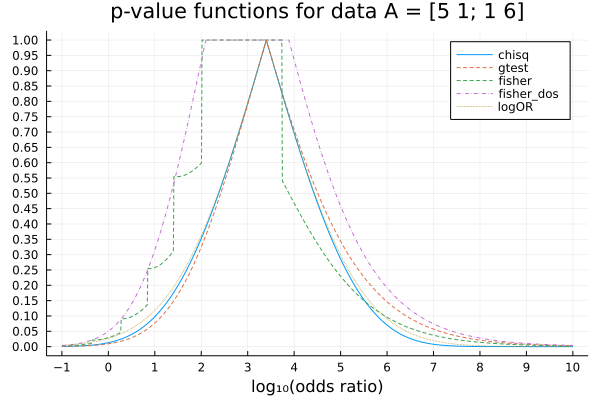

In [10]:
t = range(log(10, 1e-1), log(10, 1e10), length=1000)
p_chisq = pval_chisq.(A..., exp.(t))
p_gtest = pval_gtest.(A..., exp.(t))
p_fisher = pval_fisher.(A..., exp.(t))
p_fisher_dos = pval_fisher_dos.(A..., exp.(t))
p_logOR = pval_logOR.(A..., exp.(t))

plot(t, p_chisq; label="chisq")
plot!(t, p_gtest; label="gtest", ls=:dash)
plot!(t, p_fisher; label="fisher", ls=:dash)
plot!(t, p_fisher_dos; label="fisher_dos", ls=:dashdot)
plot!(t, p_logOR; label="logOR", ls=:dot)
title!("p-value functions for data A = $A")
plot!(; xlabel="log₁₀(odds ratio)")
plot!(; xtick=-20:20, ytick=0:0.05:1)